<a href="https://colab.research.google.com/github/Srigowri/GPULouvain/blob/main/CPUDICT_LOUVAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import cupy as cp
import random
from numba import vectorize

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


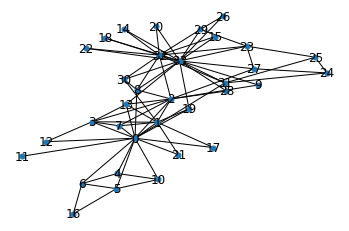

In [ ]:
g = nx.karate_club_graph()
print(nx.info(g))
sp = nx.spring_layout(g)
plt.axis("off")
nx.draw_networkx(g,pos=sp,node_size=25)
plt.show()

In [ ]:
MAXIMUM_PASSES = -1
MIN_MODULARITY = 0.0000001

In [ ]:
class Louvain():
    def __init__(self,resolution=1.0,weight_key='weight'):
        self.resolution = resolution
        self.weight_key = weight_key

    def init_graph_param(self,graph):
        self.count = 0
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight = self.weight_key)
        self.loops = dict([])

        for node in graph.nodes():
            self.node2com[node] = self.count
            deg = float(graph.degree(node, weight= self.weight_key))
            if deg < 0:
                error = "Bad node degree ({})".format(deg)
                raise ValueError(error)
            self.degrees[self.count] = deg
            self.gdegrees[node] = deg
            edge_data = graph.get_edge_data(node, node, default={self.weight_key: 0})
            self.loops[node] = float(edge_data.get(self.weight_key, 1))
            self.internals[self.count] = self.loops[node]
            self.count += 1

    def modularity(self):
        links = float(self.total_weight)
        result = 0.
        if links > 0: 
            for community in set(self.node2com.values()):
                in_degree = self.internals.get(community, 0.)
                degree =   self.degrees.get(community, 0.)            
                result += (in_degree * self.resolution / links) -  ((degree / (2. * links)) ** 2)
        return result

    @staticmethod
    def randomize(items):
        randomized_items = list(items)
        np.random.shuffle(randomized_items)
        # cp.random.shuffle(cp.array(randomized_items))
        return randomized_items

    def neighcom(self,node,graph):
        """
        Compute the communities in the neighborhood of node in the graph given
        with the decomposition node2com
        """
        weights = {}
        for neighbor, datas in graph[node].items():
            if neighbor != node:
                edge_weight = datas.get(self.weight_key, 1)
                neighborcom = self.node2com[neighbor]
                weights[neighborcom] = weights.get(neighborcom, 0) + edge_weight
        return weights


    def remove(self,node, community, weight):
        """ Remove node from community com and modify status"""
        self.degrees[community] = (self.degrees.get(community, 0.) - self.gdegrees.get(node, 0.))
        self.internals[community] = float(self.internals.get(community, 0.) - weight - self.loops.get(node, 0.))
        self.node2com[node] = -1

    def insert(self,node, community, weight):
        """ Insert node into community and modify status"""
        self.node2com[node] = community
        self.degrees[community] = (self.degrees.get(community, 0.) + self.gdegrees.get(node, 0.))
        self.internals[community] = float(self.internals.get(community, 0.) + weight + self.loops.get(node, 0.))


    def first_phase(self,graph):
        """Compute one level of communities
        """
        modified = True
        nb_pass_done = 0
        new_mod = self.modularity()
        

        while modified and nb_pass_done != MAXIMUM_PASSES:
            cur_mod = new_mod
            modified = False
            nb_pass_done += 1

            
            for node in Louvain.randomize(graph.nodes()):
                com_node = self.node2com[node]
                degc_totw = self.gdegrees.get(node, 0.) / (self.total_weight * 2.)  # NOQA
                neigh_communities = self.neighcom(node,graph)
                
                remove_cost = - self.resolution * neigh_communities.get(com_node,0) + (self.degrees.get(com_node, 0.) - self.gdegrees.get(node, 0.)) * degc_totw
                self.remove(node, com_node,neigh_communities.get(com_node, 0.))
                
                best_com = com_node
                best_increase = 0
                for com, dnc in Louvain.randomize(neigh_communities.items()):
                    incr = remove_cost + self.resolution * dnc - self.degrees.get(com, 0.) * degc_totw
                    if incr > best_increase:
                        best_increase = incr
                        best_com = com
                self.insert(node, best_com,neigh_communities.get(best_com, 0.))
                
                if best_com != com_node:
                    modified = True
            new_mod = self.modularity()
            if new_mod - cur_mod < MIN_MODULARITY:
                break


def induced_graph(partition, graph, weight_key="weight"):
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())
    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas.get(weight_key, 1)
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight_key: 0}).get(weight_key, 1)
        ret.add_edge(com1, com2, **{weight_key: w_prec + edge_weight})
    return ret

def renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = set(dictionary.values())
    target = set(range(len(values)))

    if values == target:
        # no renumbering necessary
        ret = dictionary.copy()
    else:
        # add the values that won't be renumbered
        renumbering = dict(zip(target.intersection(values),
                               target.intersection(values)))
        # add the values that will be renumbered
        renumbering.update(dict(zip(values.difference(target),
                                    target.difference(values))))
        ret = {k: renumbering[v] for k, v in dictionary.items()}

    return ret


def partition_at_level(dendrogram, level):
    partition = dendrogram[0].copy()
    for index in range(1, level + 1):
        for node, community in partition.items():
            partition[node] = dendrogram[index][community]
    return partition

def detect_communities(graph,weight_key='weight',resolution=1.0):
    if graph.is_directed():
        raise TypeError("Modularity is undefined for directed graph")
    
    edges = graph.number_of_edges()
    if edges == 0:
        return {node: i for i, node in enumerate(graph.nodes())}

    dendograms = list()      
    louvain = Louvain(resolution,weight_key)
    louvain.init_graph_param(graph)
    louvain.first_phase(graph)
    
    prev_modularity = louvain.modularity()        
    partition = renumber(louvain.node2com)
    dendograms.append(partition)
    
    current_graph = induced_graph(partition,graph,weight_key)
    louvain.init_graph_param(current_graph)

    while True:
        louvain.first_phase(current_graph)
        new_modularity = louvain.modularity()        
        if abs(new_modularity - prev_modularity) < MIN_MODULARITY:
            break
        prev_modularity = new_modularity
        partition = renumber(louvain.node2com)
        dendograms.append(partition)
        current_graph = induced_graph(partition,current_graph,weight_key)
        louvain.init_graph_param(current_graph)

    return partition_at_level(dendograms,len(dendograms)-1)

In [ ]:
from collections import defaultdict

def modularity(partition,graph,weight_key='weight'):
    if graph.is_directed():
        raise TypeError("Modularity is undefined for directed graph")
    
    edges = graph.number_of_edges()

    if edges == 0:
        raise ValueError("Modularity is undefined for edgeless graph")

    within_community_degree = defaultdict(int)
    total_community_degree = defaultdict(int)
    for vertex in graph:
        community = partition[vertex]
        total_community_degree[community] += graph.degree(vertex)
        for neighbour, attributes in graph[vertex].items():
            if partition[neighbour] == community:
                edge_weight = attributes.get(weight_key,1)
                if neighbour == vertex: #loop 
                    within_community_degree[community] += edge_weight 
                else:
                    within_community_degree[community] += edge_weight /2

    mod = 0.
    for community in set(partition.values()):
        mod += (     ( within_community_degree[community]/(edges))
                   - (   total_community_degree[community]/(2*edges)) ** 2
                )
    return mod

In [ ]:
graph = nx.karate_club_graph()
part = detect_communities(graph)
print(modularity(part, graph))

# graph = nx.read_pajek('karate.paj')
# part = detect_communities(graph)
# print(modularity(part, graph))

0.4188034188034188


In [ ]:
import requests
import gzip
import shutil 

def get_snapdata(path,ext="txt"):

    gzfilename = path.split("/")[-1]
    with open(gzfilename, "wb") as f:
        r = requests.get(path)
        f.write(r.content)

    path = gzfilename[:-3]

    with gzip.open(gzfilename, 'rb') as f_in:
        with open(path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    if ext == "txt":
        g = nx.read_edgelist(path,create_using=nx.Graph(), nodetype=int)        
    elif ext =="paj" or ext =="net":
        g = nx.read_pajek(path)
    elif ext=="gml":    
        g = nx.read_gml(path)
    return g
    
graph = get_snapdata("http://snap.stanford.edu/data/facebook_combined.txt.gz","txt")
part = detect_communities(graph)
print(modularity(part, graph))
print(part)

0.8349039221167849
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 2, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 13